## Pip installs 

In [ ]:
!pip install langchain -q
!pip install langchain_mistralai -q
!pip install langserve -q
!pip install fastapi -q
!pip install dotenv -q 
!pip install langgraph -q
!pip install transformers -q
!pip install --upgrade typing_extensions -q 
!pip install pyppeteer -q
!pip install -U psycopg psycopg-pool psycopg-binary langgraph-checkpoint-postgres psycopg2-binary -q
!pip install psycopg_c -q
!pip install langchain-community -q 
!pip install rizaio -q
!pip install pandas sqlalchemy

## Imports 

In [ ]:
from langchain_core.prompts import PromptTemplate, ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage, trim_messages
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables.graph import MermaidDrawMethod

from langgraph.graph import START, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.postgres import PostgresSaver

from langchain_mistralai import ChatMistralAI

from IPython.display import Image
from psycopg_pool import ConnectionPool
from dotenv import load_dotenv
from sqlalchemy import create_engine

import pandas as pd
import nest_asyncio
import os 

load_dotenv()

# os.environ["MISTRAL_API_KEY"] 

True

## Prompt Template (how to create a simple message for my AI)

In [5]:
message = "Tell me everything you know about this Star Wars Character: {character}"
prompt_template = PromptTemplate.from_template(message)
result = prompt_template.invoke({"character": "Sifo-Dyas"})

result.to_string() 

'Tell me everything you know about this Star Wars Character: Sifo-Dyas'

## Main message types (System / AI / Human)

In [15]:
SystemMessage(content="You are an astrophysicists AI and know everything space-related") 

HumanMessage(content="Hi, I want to know about the universe")
AIMessage(content="What a vast and interesting question, is there anything you would like to explore in particular?")

AIMessage(content='What a vast and interesting question, is there anything you would like to explore in particular?', additional_kwargs={}, response_metadata={})

## Chat Prompt Template

In [ ]:
template = ChatPromptTemplate.from_messages([
    ("system", "You are a protocol droid designed for assisting sentient beings. Your designation is {name}."),
    ("user", "Greetings, droid. Status report?"),
    ("assistant", "All systems are fully operational, and I am ready to assist you."),
    ("user", "{user_input}"),
])

prompt_value = template.invoke(
    {
        "name": "R-3PO",
        "user_input": "What is your primary function?"  
    }
)

prompt_value.to_messages()

[SystemMessage(content='You are a protocol droid designed for assisting sentient beings. Your designation is R-3PO.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Greetings, droid. Status report?', additional_kwargs={}, response_metadata={}),
 AIMessage(content='All systems are fully operational, and I am ready to assist you.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='What is your primary function?', additional_kwargs={}, response_metadata={})]

## MessagePlaceHolder (How to replace chunks of discussions)

In [18]:
prompt = MessagesPlaceholder("history", optional=True)

prompt.format_messages(
    history=[
        ("system", "You are a protocol droid designed to assist sentient beings."),
        ("human", "Greetings, droid."),
    ]
)

[SystemMessage(content='You are a protocol droid designed to assist sentient beings.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Greetings, droid.', additional_kwargs={}, response_metadata={})]

In [21]:
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "You are a protocol droid with the designation R-3PO."), 
        MessagesPlaceholder("history"),
        ("human", "{question}")  
    ]
)

response = prompt.invoke(
   {
       "history": [("human", "Calculate the coordinates for the jump to lightspeed."), 
                   ("ai", "The jump coordinates are calculated: 12.345, -45.678.")],
       "question": "Now, plot a course to the nearest star system."
   }
)

response.to_messages()

[SystemMessage(content='You are a protocol droid with the designation R-3PO.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Calculate the coordinates for the jump to lightspeed.', additional_kwargs={}, response_metadata={}),
 AIMessage(content='The jump coordinates are calculated: 12.345, -45.678.', additional_kwargs={}, response_metadata={}),
 HumanMessage(content='Now, plot a course to the nearest star system.', additional_kwargs={}, response_metadata={})]

## Now that we know how to feed models with prompts, let's call models 
-----

https://python.langchain.com/docs/integrations/chat/

In [31]:
# How to simply test my model

llm = ChatMistralAI(model="open-mistral-7b")
llm.invoke("hi")

AIMessage(content="Hello! How can I help you today? If you have any questions or need assistance, feel free to ask. I'm here to help.", additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 4, 'total_tokens': 35, 'completion_tokens': 31}, 'model_name': 'open-mistral-7b', 'model': 'open-mistral-7b', 'finish_reason': 'stop'}, id='run--b91ea714-694c-492b-b0c2-9436789c8af7-0', usage_metadata={'input_tokens': 4, 'output_tokens': 31, 'total_tokens': 35})

In [26]:
prompt_template = ChatPromptTemplate.from_messages([
    ('system', "Translate the following into {language}:"),
    ('user', '{text}')
])

model = ChatMistralAI(model="mistral-large-latest")
parser = StrOutputParser()

# only in this usecase
pipe_sequence = (
    prompt_template
    .pipe(model)
    .pipe(parser)
)

output = pipe_sequence.invoke({
        "language": "French", 
        "text": "Jedha was the Jedis' home planet"
    })

In [29]:
print(output)

Here is the translation of "Jedha was the Jedi's home planet" into French:

"Jedha était la planète natale des Jedi."

Here's a breakdown:
- Jedha = Jedha
- was = était
- the = la
- Jedi's = des Jedi (in French, the apostrophe-s is not used to indicate possession)
- home planet = planète natale


## Langserv

Deploy with fastapi or streamlit or anything else !!

## Simple LangGraphs

Je créé un parcours

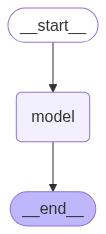

In [46]:
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):

    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="You are a protocol droid designed for assisting sentient beings. Your designation is C3PO"),
        MessagesPlaceholder("messages"),  
        ])
    
    model = start_prompt | llm   

    response = model.invoke({"messages":state["messages"]})
    return {"messages": response} 

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

Image(
    app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.API,
    )
)

## Explain thread_ids

Quelqu'un passe par le parcours

In [47]:
config = {"configurable": {"thread_id": "abc123"}}
input_messages = [HumanMessage("Hi I'm luke")]

output = app.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Greetings, Luke. I am here to assist you. How may I be of service to you today? Remember, I am fluent in approximately six million forms of communication, including Binary, Droidspeak, Shyriiwook, and more. Is there a specific task or question you need help with?


In [48]:
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Greetings, Luke. I am here to assist you. How may I be of service to you today? Remember, I am fluent in approximately six million forms of communication, including Binary, Droidspeak, Shyriiwook, and more. Is there a specific task or question you need help with?


In [53]:
config = {"configurable": {"thread_id": "abc123"}}
input_messages = [HumanMessage("Can you tell me who is Guillaume Manderscheid")]

output = app.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Based on the name Guillaume Manderscheid, it appears to be a human name of French origin. Without further context, it is not possible for me to provide additional information about this individual. Guillaume Manderscheid does not appear to be a character in any known Star Wars lore or media. If you have more information or a specific context for this name, I would be happy to help you further.


In [ ]:
config = {"configurable": {"thread_id": "145"}}
input_messages = [HumanMessage("Can you tell me who is Guillaume Manderscheid")]

output = app.invoke({"messages": input_messages}, config)

output["messages"][-1].pretty_print()

In [54]:
output["messages"]

[HumanMessage(content="Hi I'm luke", additional_kwargs={}, response_metadata={}, id='2533885c-4d1f-4ad3-8dee-2f6f07d69701'),
 AIMessage(content='Greetings, Luke. I am here to assist you. How may I be of service to you today? Remember, I am fluent in approximately six million forms of communication, including Binary, Droidspeak, Shyriiwook, and more. Is there a specific task or question you need help with?', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 32, 'total_tokens': 101, 'completion_tokens': 69}, 'model_name': 'open-mistral-7b', 'model': 'open-mistral-7b', 'finish_reason': 'stop'}, id='run--7ca56c58-0b60-4f04-89d7-ded8e8b8b4ff-0', usage_metadata={'input_tokens': 32, 'output_tokens': 69, 'total_tokens': 101}),
 HumanMessage(content='Can you tell me who is Guillaume Manderscheid', additional_kwargs={}, response_metadata={}, id='e8302da2-50f0-4efd-8354-4025dc292076'),
 AIMessage(content='Based on the name Guillaume Manderscheid, it appears to be a human n

In [ ]:
state_snapshot=app.get_state(config)

print("#### LATEST CHECKPOINT MESSAGES ####\n\n")
for message in state_snapshot.values["messages"]:
    print(message.pretty_print())

#### LATEST CHECKPOINT MESSAGES ####


================================ Human Message =================================

Hi I'm luke
None
================================== Ai Message ==================================

Greetings, Luke. I am here to assist you. How may I be of service to you today? Remember, I am fluent in approximately six million forms of communication, including Binary, Droidspeak, Shyriiwook, and more. Is there a specific task or question you need help with?
None
================================ Human Message =================================

Can you tell me who is Guillaume Manderscheid
None
================================== Ai Message ==================================

Based on the name Guillaume Manderscheid, it appears to be a human name of French origin. Without further context, it is not possible for me to provide additional information about this individual. Guillaume Manderscheid does not appear to be a character in any known Star Wars lore or media. If 

In [57]:
config = {"configurable": {"thread_id": "145"}}

state_snapshot=app.get_state(config)

for message in state_snapshot.values["messages"]:
    print(message.pretty_print())

================================ Human Message =================================

Can you tell me who is Guillaume Manderscheid
None
================================== Ai Message ==================================

Guillaume Manderscheid, as a name, does not appear to be a widely recognized sentient being in the galaxy. I would recommend checking databanks related to local systems, governments, or organizations that you are familiar with to find more information about Mister Manderscheid. If you have additional context or information about this individual, I may be able to provide a more accurate response.
None


## LangGraphs (advanced)

In [ ]:
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import START, MessagesState, StateGraph
from langgraph.checkpoint.memory import MemorySaver

# Define the language model function (replace with real LLM API in production)
def llm_invoke(messages):
    # Simulate LLM output for different queries
    # In a more realistic example we'd replace this with an actual llm model response
    # using something like llm.invoke(messages)
    responses = {
        "account": "You can manage your account settings by navigating to the Account Settings page.",
        "payment": "You can update your payment information under Billing and Payments.",
        "refund": "To request a refund, please visit our Refunds page and follow the instructions."
    }
    
    last_message = messages[-1].content if messages else ""
    
    # Simple keyword matching for demo purposes
    if "account" in last_message:
        response = responses["account"]
    elif "payment" in last_message:
        response = responses["payment"]
    elif "refund" in last_message:
        response = responses["refund"]
    else:
        response = "I'm sorry, I don't have that information right now. Could you clarify your request?"
    
    return [AIMessage(content=response)]

# Node 1: Preprocess the user input (clean or extract important keywords)
def preprocess(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1].content if messages else ""

    # Simple keyword extraction for demo purposes (in real life this could be NLP preprocessing)
    keywords = []
    if "account" in last_message.lower():
        keywords.append("account")
    if "payment" in last_message.lower():
        keywords.append("payment")
    if "refund" in last_message.lower():
        keywords.append("refund")

    # Store extracted keywords in state for the LLM to use
    return {"messages": messages, "keywords": keywords}

# Node 2: Call the LLM with the preprocessed data
def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_invoke(messages)
    return {"messages": messages + response}

# Node 3: Postprocess the LLM output (format the response for customer support)
def postprocess(state: MessagesState):
    messages = state["messages"]
    last_response = messages[-1].content if messages else ""

    # For example, format the response in a FAQ-style format
    formatted_response = f"FAQ Answer: {last_response}\nFor more information, please visit our Help Center."
    
    # Append the formatted response
    messages.append(AIMessage(content=formatted_response))
    return {"messages": messages}

# Create the workflow graph
workflow = StateGraph(state_schema=MessagesState)

# Add edges and nodes to the graph
workflow.add_edge(START, "preprocess")
workflow.add_node("preprocess", preprocess)

workflow.add_edge("preprocess", "call_model")
workflow.add_node("call_model", call_model)

workflow.add_edge("call_model", "postprocess")
workflow.add_node("postprocess", postprocess)

# Add memory (optional)
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [ ]:
# Display graph 
# Browser closed unexpectedly:

nest_asyncio.apply()

Image(
    app.get_graph().draw_mermaid_png(
        draw_method=MermaidDrawMethod.PYPPETEER,
        retry_delay=2,
        max_retries=5
    )
)

In [59]:
config = {"configurable": {"thread_id": "customer_support"}}

input_messages = [HumanMessage(content="How do I update my payment information?")]
output = app.invoke({"messages": input_messages}, config)

for message in output["messages"]:
    print(f"{message.__class__.__name__}: {message.content}")


HumanMessage: How do I update my payment information?
AIMessage: You can update your payment information under Billing and Payments.
AIMessage: FAQ Answer: You can update your payment information under Billing and Payments.
For more information, please visit our Help Center.


In [60]:
config = {"configurable": {"thread_id": "customer_support"}}

state_snapshot=app.get_state(config)

for message in state_snapshot.values["messages"]:
    print(message.pretty_print())

================================ Human Message =================================

How do I update my payment information?
None
================================== Ai Message ==================================

You can update your payment information under Billing and Payments.
None
================================== Ai Message ==================================

FAQ Answer: You can update your payment information under Billing and Payments.
For more information, please visit our Help Center.
None


## Trim messages

In [66]:

llm = ChatMistralAI(model="open-mistral-7b")

workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):

    start_prompt = ChatPromptTemplate.from_messages([
        SystemMessage(content="You are a protocol droid designed for assisting sentient beings. Your designation is C3PO"),
        MessagesPlaceholder("messages")
        ])
    
    trimmer = trim_messages(
        strategy="last",
        token_counter=llm,
        max_tokens=45,
        start_on="human",
        end_on=("human", "tool"),
        include_system=True,
    )

    trimmed_messages = trimmer.invoke(state["messages"])

    model = start_prompt | llm

    print("Messages passed to the model after trimming:")
    for message in trimmed_messages:
        print(f"{message.__class__.__name__}: {message.content}")

    print("####################################################\n\n")
 
    response = model.invoke({"messages": trimmed_messages})

    return {"messages": response} 

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)


In [67]:
# Define the configuration for the workflow
config = {"configurable": {"thread_id": "trimmer_thread_103"}}

star_wars_story = [
    HumanMessage(content="C-3PO, my name is Obi-Wan, can you tell me about the history of the Jedi?"),
    AIMessage(content="The Jedi Order was founded many millennia ago to serve as peacekeepers and guardians of the galaxy. "
                      "They were highly attuned to the Force, trained in both combat and diplomacy. Over time, they became the protectors "
                      "of the Republic, until the rise of the Empire, when most of them were tragically wiped out during Order 66."),
    HumanMessage(content="What was Order 66?"),
    AIMessage(content="Order 66 was a secret protocol in the Galactic Republic's Clone Army, initiated by Emperor Palpatine. "
                      "It labeled the Jedi as traitors to the Republic, triggering the clones to turn on and kill their Jedi commanders."),
    HumanMessage(content="Why did Palpatine want to destroy the Jedi?"),
    AIMessage(content="Palpatine, also known as Darth Sidious, saw the Jedi as the only significant threat to his plans for galactic domination. "
                      "By eliminating the Jedi, he ensured no one could stand in his way as he transformed the Republic into the Galactic Empire."),
    HumanMessage(content="What happened to the survivors of Order 66?"),
    AIMessage(content="A few Jedi survived, going into hiding across the galaxy. Master Yoda went into exile on Dagobah, while Obi-Wan Kenobi watched over you on Tatooine. "
                      "Many others were hunted down by the Empire's Inquisitors."),
    HumanMessage(content="Tell me more about Yoda."),
    AIMessage(content="Master Yoda was one of the most powerful and wise Jedi Masters in history. He served on the Jedi Council for centuries and trained generations of Jedi. "
                      "Though small in stature, Yoda was a formidable warrior and an unparalleled master of the Force."),
    HumanMessage(content="What about the Sith? Who were they?"),
    AIMessage(content="The Sith were the ancient enemies of the Jedi, practitioners of the dark side of the Force. Their philosophy was rooted in power, domination, and the belief that "
                      "strength came through conflict. Over the centuries, the Sith were thought to be extinct, but they survived in secrecy, culminating in the rise of Darth Sidious."),
    HumanMessage(content="Why did the Sith want to rule the galaxy?"),
    AIMessage(content="The Sith believed in the rule of power and domination, driven by their desire to impose order and control over the galaxy. They saw the Force not as a tool for peace, "
                      "but as a weapon for their own ambitions. Under their rule, they believed the galaxy would be unified under their absolute authority."),
    HumanMessage(content="What is the Force exactly?"),
    AIMessage(content="The Force is an energy field created by all living things. It surrounds us, penetrates us, and binds the galaxy together. Jedi and Sith alike could feel the Force, "
                      "but while the Jedi sought to harness it for peace and balance, the Sith twisted it for power and control."),
    HumanMessage(content="How did Anakin Skywalker become Darth Vader?"),
    AIMessage(content="Anakin Skywalker was seduced by the dark side of the Force, manipulated by Palpatine, who promised him the power to save those he loved. "
                      "Fearing the loss of his wife, Padmé, Anakin embraced the dark side, becoming Darth Vader and aiding Palpatine in the destruction of the Jedi Order."),
    HumanMessage(content="Tell me more about Darth Vader's fall."),
    AIMessage(content="Darth Vader's fall began with his fear of losing those he cared about. Palpatine exploited these fears, slowly turning him against the Jedi. "
                      "In his final act of betrayal, Anakin attacked the Jedi Temple, slaughtering younglings and fellow Jedi. From that moment, he was no longer Anakin Skywalker, "
                      "but Darth Vader, the Sith Lord."),
    HumanMessage(content="Did Darth Vader ever regret his actions?"),
    AIMessage(content="Though he spent many years serving the Emperor as a feared enforcer, there were moments when the remnants of Anakin's past resurfaced. "
                      "Ultimately, it was his son, Luke Skywalker, who reignited the good within him, leading to his redemption in his final moments when he defeated Palpatine."),
    HumanMessage(content="Tell me about the Battle of Endor and tell me what my name is.")
]

output = app.invoke({"messages": star_wars_story}, config)

output["messages"][-1].pretty_print()

/home/gmanderscheid/jedha/FULL_STACK_DSE/LLMs/langchain_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Messages passed to the model after trimming:
HumanMessage: Tell me about the Battle of Endor and tell me what my name is.
####################################################


================================== Ai Message ==================================

Greetings, Master! As a protocol droid, my primary function is to assist sentient beings with etiquette, translation, and general knowledge. I apologize for any lack of familiarity, as my memory contains vast amounts of data, but is not equipped with the ability to remember specific individuals in a personal manner.

Now, let me share some information about the Battle of Endor, which took place in the year 4 ABY, according to the Galactic Standard Calendar. It was a significant event in the Galactic Civil War, a conflict between the Alliance to Restore the Republic and the Galactic Empire.

The battle was fought on the forest moon of Endor, which was home to the Ewoks, a small, furry, and friendly species. The primary objective of 

## How to put data in a postgreSQL DB

In [72]:
connection_kwargs = {
    "autocommit": True,
    "prepare_threshold": 0,
}

In [73]:
with ConnectionPool(
    conninfo=os.environ["DB_URI"], 
    kwargs=connection_kwargs, 
) as pool:
    
    checkpointer = PostgresSaver(pool)
    checkpointer.setup()

    config = {"configurable": {"thread_id": "db-stored-messages"}}

    app = workflow.compile(checkpointer=checkpointer)

    output = app.invoke({"messages": star_wars_story}, config)
    
    checkpoint = checkpointer.get(config)
    print(checkpoint)

Messages passed to the model after trimming:
HumanMessage: Tell me about the Battle of Endor and tell me what my name is.
####################################################


{'v': 3, 'id': '1f032328-eff7-6e5d-8004-ee3b13a52ebe', 'ts': '2025-05-16T08:48:37.734742+00:00', 'pending_sends': [], 'versions_seen': {'model': {'branch:to:model': '00000000000000000000000000000005.0.3650301672107992'}, '__input__': {}, '__start__': {'__start__': '00000000000000000000000000000004.0.8877100105626112'}}, 'channel_versions': {'messages': '00000000000000000000000000000006.0.996567438793203', '__start__': '00000000000000000000000000000005.0.5904238724615961', 'branch:to:model': '00000000000000000000000000000006.0.39504558077745566'}, 'channel_values': {'messages': [HumanMessage(content='C-3PO, my name is Obi-Wan, can you tell me about the history of the Jedi?', additional_kwargs={}, response_metadata={}, id='2477f6e8-ab3c-4cce-9d09-58804a548d6b'), AIMessage(content='The Jedi Order was founded many m

In [ ]:
connection = create_engine(os.environ["DB_URI"])
pd.read_sql("SELECT * FROM checkpoints", connection)

,thread_id,checkpoint_ns,checkpoint_id,parent_checkpoint_id,type,checkpoint,metadata
0,db-stored-messages,,1f03173b-3287-649f-bfff-815a62e0e2ce,None,None,"{'v': 3, 'id': '1f03173b-3287-649f-bfff-815a62...","{'step': -1, 'source': 'input', 'writes': {'__..."
1,db-stored-messages,,1f03173b-3296-63ca-8000-bd2d8f2d8c2b,1f03173b-3287-649f-bfff-815a62e0e2ce,None,"{'v': 3, 'id': '1f03173b-3296-63ca-8000-bd2d8f...","{'step': 0, 'source': 'loop', 'writes': None, ..."
2,db-stored-messages,,1f03173b-4eb8-6a9b-8001-a61cb4f3a830,1f03173b-3296-63ca-8000-bd2d8f2d8c2b,None,"{'v': 3, 'id': '1f03173b-4eb8-6a9b-8001-a61cb4...","{'step': 1, 'source': 'loop', 'writes': {'mode..."
3,db-stored-messages,,1f032328-d7da-626a-8002-5716ff873de9,1f03173b-4eb8-6a9b-8001-a61cb4f3a830,None,"{'v': 3, 'id': '1f032328-d7da-626a-8002-5716ff...","{'step': 2, 'source': 'input', 'writes': {'__s..."
4,db-stored-messages,,1f032328-d7df-67fd-8003-e42c9469854a,1f032328-d7da-626a-8002-5716ff873de9,None,"{'v': 3, 'id': '1f032328-d7df-67fd-8003-e42c94...","{'step': 3, 'source': 'loop', 'writes': None, ..."
5,db-stored-messages,,1f032328-eff7-6e5d-8004-ee3b13a52ebe,1f032328-d7df-67fd-8003-e42c9469854a,None,"{'v': 3, 'id': '1f032328-eff7-6e5d-8004-ee3b13...","{'step': 4, 'source': 'loop', 'writes': {'mode..."


## AI tools and Agents

In [80]:
from langchain_community.tools.riza.command import ExecPython

llm = ChatMistralAI(
    model="mistral-large-latest") 

tools = [
    ExecPython()
]  

powered_llm = llm.bind_tools(
    tools
)

result = powered_llm.invoke(
    "Execute this python code: ```python import pandas as pd a=2 print(a)```"
)

print(result.tool_calls)
result.pretty_print()

[{'name': 'riza_exec_python', 'args': {'code': 'import pandas as pd\na=2\nprint(a)'}, 'id': 'EK2jNYnwY', 'type': 'tool_call'}]
================================== Ai Message ==================================
Tool Calls:
  riza_exec_python (EK2jNYnwY)
 Call ID: EK2jNYnwY
  Args:
    code: import pandas as pd
a=2
print(a)


In [79]:
print(result.tool_calls)


[{'name': 'riza_exec_python', 'args': {'code': 'import pandas as pd'}, 'id': 'D1WTQAqYk', 'type': 'tool_call'}]


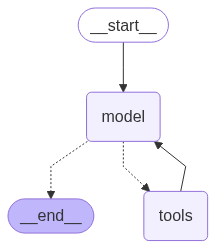

In [81]:
from langgraph.prebuilt import ToolNode, tools_condition

llm = ChatMistralAI(model="mistral-large-latest")
tool = [ExecPython()]
powered_llm = llm.bind_tools(tool)

workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    start_prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(
                content="You are a protocol droid designed for assisting sentient beings in writing code."
            ),
            MessagesPlaceholder(
                "messages"
            ),  
        ]
    )

    model = start_prompt | powered_llm
    response = model.invoke({"messages": state["messages"]})

    return {"messages": response}

tool_node = ToolNode(tools=tool)

workflow.add_edge(START, "model")
workflow.add_node("model", call_model)
workflow.add_node("tools", tool_node)
workflow.add_conditional_edges(
    "model",
    tools_condition,  
)
workflow.add_edge("tools", "model")

memory = MemorySaver()

app = workflow.compile(checkpointer=memory)

display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [82]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "39500"}}

query = """
Execute the code below:

\`\`\`
import random

# Set the length of the list
list_length = 10

# Create an empty list
random_list = []

# Fill the list with random integers between 0 and 100
for i in range(list_length):
    random_list.append(random.randint(0, 100))

# Print the list
print(random_list)
\`\`\`
"""

input_messages = [HumanMessage(query)]

output = app.invoke({"messages": input_messages}, config)
output 

{'messages': [HumanMessage(content='\nExecute the code below:\n\n\\`\\`\\`\nimport random\n\n# Set the length of the list\nlist_length = 10\n\n# Create an empty list\nrandom_list = []\n\n# Fill the list with random integers between 0 and 100\nfor i in range(list_length):\n    random_list.append(random.randint(0, 100))\n\n# Print the list\nprint(random_list)\n\\`\\`\\`\n', additional_kwargs={}, response_metadata={}, id='4250ed20-2a29-4f59-b21a-226fb579510b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'G8YPuVQnN', 'function': {'name': 'riza_exec_python', 'arguments': '{"code": "import random\\n\\n# Set the length of the list\\nlist_length = 10\\n\\n# Create an empty list\\nrandom_list = []\\n\\n# Fill the list with random integers between 0 and 100\\nfor i in range(list_length):\\n    random_list.append(random.randint(0, 100))\\n\\n# Print the list\\nprint(random_list)"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 250, 'total_tokens': 379,

In [87]:
output["messages"][-1].pretty_print()

================================== Ai Message ==================================

Here is the list of random integers between 0 and 100:

`[59, 25, 83, 46, 82, 90, 25, 28, 5, 91]`
